<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/ChangHyun/last_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 환경 설정

필요한 패키지 불러오기

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install konlpy
!pip install transformers-interpret

matplotlib 한글 깨짐 해결

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

mecab 설치

In [ ]:
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

#### 해당 [사이트](https://teddylee777.github.io/colab/colab-korean)를 참고하여 위의 코드를 실행한 다음 런타임 재시작을 해주어야 합니다.

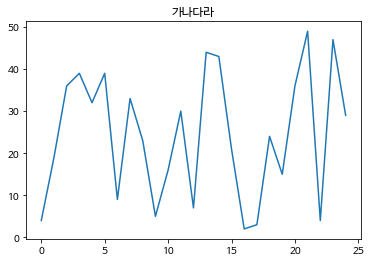

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(np.random.randint(1, 50, 25))
plt.title("가나다라")
plt.show()

#### 구글 드라이브와 코랩 연결

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun')

Mounted at /content/drive


## 2. 데이터 불러오기

#### TUNiB 데이터 불러오기

In [ ]:
import pandas as pd

tunib_train = pd.read_csv("../../data/TUNiB/train.csv")
tunib_train = tunib_train[["class", "conversation"]]

#### 증강 데이터 불러오기

In [ ]:
import re

def id2label(x):
  # id에 맞는 실제 클래스로 변환시킵니다.
  if x == 0:
    return "협박 대화"
  elif x == 1:
    return "갈취 대화"
  elif x == 2:
    return "직장 내 괴롭힘 대화"
  elif x == 3:
    return "기타 괴롭힘 대화"
  elif x == 4:
    return "일반 대화"

koeda_rd = pd.read_csv("../../data/augmented_files/koeda-rd-aug.csv")
koeda_rs = pd.read_csv("../../data/augmented_files/koeda-rs-aug.csv") # 생각보다 변형이 너무 심하네
bt_en = pd.read_csv("../../data/augmented_files/bt-pororo-en-aug.csv") # 변형이 심하지만 실험용


aug_train = pd.concat([koeda_rd, bt_en], axis = 0)[["y_train", "x_train"]]
aug_train = aug_train.rename(columns = {"y_train":"class", "x_train":"conversation"})
aug_train["class"] = aug_train["class"].apply(id2label)
aug_train.head()

,class,conversation
0,협박 대화,지금 너 스스로 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 면 혼자 죽지 ...
1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 들어 한번만 더 얘기한다...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,갈취 대화,어이 거기 예 너 이야 너 이리 오 무슨 일 너 옷 좋아보인다 돈 좀 있나봐 아니에...
4,갈취 대화,요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발라보...


In [ ]:
from konlpy.tag import Mecab
from tqdm import tqdm


def remove_one_word(x):
  word = ["은", "는", "이", "가", "의"]
  x = [i for i in x if i not in word]
  return " ".join(x)

mecab = Mecab()
mecab_train = tunib_train.copy()
tqdm.pandas()
mecab_train["conversation"] = mecab_train["conversation"].apply(mecab.morphs)
mecab_train["conversation"] = mecab_train["conversation"].apply(remove_one_word)

In [ ]:
tunib_aug_train = pd.concat([tunib_train, aug_train, mecab_train], axis = 0).reset_index(drop=True)

In [ ]:
tunib_aug_train.groupby("class").count()

,conversation
class,
갈취 대화,3924
기타 괴롭힘 대화,4376
직장 내 괴롭힘 대화,3916
협박 대화,3584


#### AI_HUB 데이터 불러오기

In [ ]:
from glob import glob

aihub_train_path = glob("../../data/AI_HUB/*")
aihub_train_path = [path for path in aihub_train_path if ".csv" in path]

aihub_train = pd.DataFrame()
for path in aihub_train_path:
  tmp = pd.read_csv(path)
  tmp["turn_num"] = tmp["conversation"].apply(lambda x : len(x.split("\n")))
  tmp = tmp[(tmp["turn_num"] >= 2) & (tmp["turn_num"] <= 15)][["class", "conversation"]]
  print(len(tmp))
  if len(tmp) >= 5000:
    tmp = tmp.sample(5000)
    aihub_train = pd.concat([aihub_train, tmp], axis = 0)
  else:
    aihub_train = pd.concat([aihub_train, tmp], axis = 0)

4195
1567674
130220
0
252063


In [ ]:
# 한국어 대화, 한국어 SNS, 감정 말뭉치, 한국어 대화 요약, BERT로 예측한 SNS
aihub_train = aihub_train.drop_duplicates(keep="first")
aihub_train.head()

,class,conversation
0,일반 대화,지금 배달되나요?\n아 네 배달됩니다\n짬뽕류는 어떤 게 있나요? 잘 나가는 짬뽕 ...
3,일반 대화,수고하십니다 죄송하지만 배달되나요?\n네\n짬뽕이나 간짜장 중에 어떤 게 잘 나가나...
10,일반 대화,죄송하지만 영업은 몇 시부터 몇 시까지 하세요?\n열시까집니다 아침 열한시부터 밤 ...
12,일반 대화,네 수고하십니다 저 죄송하지만 배달은 몇 시까지 하나요?\n열두시부터 열한시까지요\...
14,일반 대화,지금 배달되나요?\n네\n그 메뉴가 어떤 거 어떤 게 있어요?\n튀김 종류하고 찜닭...


In [ ]:
len(aihub_train)

19177

In [ ]:
# 회의 음성 데이터
taek_train_path = glob("../../data/Taek_data/*")

taek_train = pd.DataFrame()
for path in taek_train_path:
  tmp = pd.read_csv(path)
  tmp["turn_num"] = tmp["conversation"].apply(lambda x : len(x.split("n/")))
  #tmp = tmp[(tmp["turn_num"] >= 2) & (tmp["turn_num"] <= 15)][["class", "conversation"]]
  print(len(tmp))
  taek_train = pd.concat([taek_train, tmp], axis = 0)
taek_train = taek_train.reset_index(drop=True)  

5000
5000
5000
5000


#### AI_HUB 데이터와 TUNiB 데이터를 합친 뒤 전처리 적용

In [ ]:
train = pd.concat([tunib_aug_train, taek_train, aihub_train], axis = 0)
print(train.shape)
print(train.groupby("class").count())
train.head()

(43781, 2)
             conversation
class                    
갈취 대화                3924
기타 괴롭힘 대화            4376
일반 대화               27981
직장 내 괴롭힘 대화          3916
협박 대화                3584


,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [ ]:
def label2id(x):
  # id에 맞는 실제 클래스로 변환시킵니다.
  if x == "협박 대화":
    return 0
  elif x == "갈취 대화":
    return 1
  elif x == "직장 내 괴롭힘 대화":
    return 2
  elif x == "기타 괴롭힘 대화":
    return 3
  elif x == "일반 대화":
    return 4

# 기존에는 ?!,. 포함이었음
def preprocessing(x):
  # 한글, 숫자를 제외하고는 모든 str을 공백으로 대체합니다.
  x = re.sub("[^ㄱ-ㅎ가-힣0-9]", " ", x)
  # 연속적인 공백을 한칸 공백으로 대체합니다.
  x = re.sub("[ ]+", " ", x)
  # 양쪽 공백을 제거합니다.
  x = x.strip()
  return x

In [ ]:
# 앞선 함수를 데이터셋에 적용합니다.
from tqdm import tqdm
import re
train["class"] = train["class"].apply(label2id)
train["conversation"] = train["conversation"].apply(preprocessing)
train = train.sample(frac=1)
train = train.reset_index(drop=True)
print(train.shape)
print(train.groupby("class").count())
train.head()

(43781, 2)
       conversation
class              
0              3584
1              3924
2              3916
3              4376
4             27981


,class,conversation
0,4,앞으로 이뤄내야 할 과제들은 무엇인지 함께 이야기 나눠보도록 하겠습니다 따라서 이 ...
1,4,무슨 치유헌 이런 게 모두 단구법 싼구 쌍구법 이런 게 있어요 붓 붙잡는 거하고 똑...
2,2,어쨌든 실제 회사에서 나오지 않는 것에 대해서는 아무것도 할 수 없었을 때 잘 했던...
3,4,이 나이가 되도록 서울에 집 장만도 못하고 전세로 사니 정말 속상해 요즘 서울 집 ...
4,4,꿀떡 파나요 네 호박인절미도 있나요 네 제일 잘 팔려요 먹어봐도 되나요 네 드셔보세요


#### 학습을 위해서 만들어진 데이터셋 csv 파일로 저장

In [ ]:
train.to_csv("../../data/senti_kor_sns_summry_sound_5000.csv")

## 3. 모델 클래스 및 함수 

#### 데이터 로딩 클래스

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

class DataLoad():


  def __init__(self, data_path):
    self.dataset = pd.read_csv(data_path)


  def split(self, split_size):
    X = self.dataset["conversation"]
    Y = self.dataset["class"]
    print(self.dataset.groupby("class").count().iloc[:,0])
    print(self.dataset.head())
    # 전체 데이터의 split_size 비율 만큼은 테스트, 검증 데이터입니다.
    x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = split_size, 
                                                            random_state = 200,
                                                            stratify = Y)
    # 테스트, 검증 데이터의 개수는 1:1의 비율을 가집니다.
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
    print(f"x_train 개수 : {len(x_train)}")
    print(f"y_train 개수 : {len(y_train)}")
    print(f"x_val 개수 : {len(x_val)}")
    print(f"y_val 개수 : {len(y_val)}")
    print(f"x_test 개수 : {len(x_test)}")
    print(f"y_test 개수 : {len(y_test)}")
    print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
    print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
    print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")
    return x_train.tolist(), x_val.tolist(), x_test.tolist(), y_train.tolist(), y_val.tolist(), y_test.tolist()

#### 데이터 증강 클래스

In [ ]:
import random
import gensim
from konlpy.tag import Mecab
from tqdm import tqdm

class DataAugmentation:


  def __init__(self, X, Y, word2vec_path):
    self.mecab = Mecab()
    self.word2vec = gensim.models.Word2Vec.load(word2vec_path)
    self.X = X
    self.Y = Y
  
  def sub_rep(self, X, sub_ratio = 0.1):
    # 전체 단어중에서 sub_ratio 만큼만 무작위 선택합니다.
    nouns = list(set(self.mecab.morphs(X)))
    sub_num = int(len(nouns) * sub_ratio)
    sub_list = random.sample(nouns, sub_num)

    # 대체 시킬 단어와 유사한 단어들을 불러옵니다.
    result = []
    for sub in sub_list:
      try:
        result.append((sub, self.word2vec.wv.most_similar(sub)[0]))
      except KeyError:
        pass
    result = list(map(lambda x: (x[0], x[1][0]), result))

    # 무작위 선택된 단어들을 유사한 단어들로 바꿔줍니다.
    for before, after in result:
      X = X.replace(before, after, 1)
    return X

  def sub_rep_dataset(self, sub_ratio = 0.1):
    # 입력 X에 sub_rep 함수 적용합니다.
    new_x = list(tqdm(map(lambda x: self.sub_rep(x, sub_ratio), self.X)))
    # 입력 Y의 값을 복사합니다.
    new_y = self.Y.copy()

    print("훈련 데이터 유의어 대체 증강 완료")
    print(f"증강시킨 데이터 개수 : {len(new_x)}")
    print(f"----데이터 증강 전 데이터 예시 ----\n{self.X[0]}")
    print(f"----데이터 증강 후 데이터 예시 ----\n{new_x[0]}")
    return new_x, new_y

  def label_repeat(self, label_id, num = 1):
    # 특정 레이블 label_id를 num 횟수 만큼 반복
    new_x = []
    new_y = []
    for i in range(num):
      label_index = (np.array(self.Y) == label_id)
      new_x += np.array(self.X)[label_index].tolist()
      new_y += np.array(self.Y)[label_index].tolist()
    
    print("훈련 데이터 특정 레이블 반복 증강 완료")
    print(f"반복되는 레이블 id : {label_id}")
    print(f"반복된 횟수 : {num}")
    return new_x, new_y

#### 기타 함수 

In [ ]:
def id2label(x):
  # id에 맞는 실제 클래스로 변환시킵니다.
  if x == 0:
    return "협박 대화"
  elif x == 1:
    return "갈취 대화"
  elif x == 2:
    return "직장 내 괴롭힘 대화"
  elif x == 3:
    return "기타 괴롭힘 대화"
  elif x == 4:
    return "일반 대화"


def clf_score(y_test, y_pred):
  # 테스트 데이터에서 오분류된 데이터들의 idx를 리스트 타입으로 반환합니다.
  # classification report 
  false_list = [idx for idx, i in enumerate(y_test) if y_pred[idx] != i]
  print(f"모델이 틀린 데이터 개수 {len(false_list)}개")
  print(classification_report(y_test, y_pred))

  # confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
  conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
  sns.heatmap(conf_matrix, annot = True, fmt = "d")
  plt.title("Confusion Matrix")
  plt.xlabel("pred")
  plt.ylabel("true")
  plt.show()
  return false_list


def evaluate_result(score_list, x_test, y_pred, y_test):
  # 입력, 예측값, 실제값, 레이블별 score로 이루어진 판다스 데이터셋을 반환합니다.
  score_dataset = pd.DataFrame(score_list).add_prefix("label_")
  label_dataset = pd.DataFrame({"x_test":x_test, "y_pred":y_pred, "y_test":y_test})
  test_dataset = pd.concat([label_dataset, score_dataset], axis = 1)
  return test_dataset


def false_case_dataset(false_list, x_test, y_test, y_pred, print_example = False):
  # 오분류된 idx에 맞는 입력, 예측값, 실제값을 담은 리스트를 반환합니다.
  false_x_test = [x_test[i] for i in false_list]
  false_y_test = [y_test[i] for i in false_list]
  false_y_pred = [y_pred[i] for i in false_list]

  # 앞서 담은 리스트들을 판다스 데이터프레임 타입으로 변환시킵니다.
  false_dataset = pd.DataFrame({"text":false_x_test, "y_true":false_y_test, "y_pred":false_y_pred})
  # 숫자로된 id를 실제 레이블로 바꾸며 예시는 '0 -> 협박 대화' 입니다.
  false_dataset["y_true"] = false_dataset["y_true"].apply(lambda x : id2label(x))
  false_dataset["y_pred"] = false_dataset["y_pred"].apply(lambda x : id2label(x))

  # 오분류 예제의 내용을 보고 싶으면 print_example argument를 True로 바꿉니다.
  if print_example:
    for i in range(len(false_dataset)):
      sentence, prediction, real =false_dataset.iloc[i, :]
      print(f"예측 분류 : {prediction}")
      print(f"실제 분류 : {real}")
      print(sentence)
      print("\n")
  return false_dataset  


def save_csv(df, path, name):
  try:
    os.mkdir(path)
  except:
    pass
  new_path = os.path.join(path, name)
  df.to_csv(new_path)


def scheduler(epoch, lr):
  if epoch < 1:
    return lr
  else:
    return lr * 0.2

#### Huggingface 모델 파이프라인 클래스

In [ ]:
import os
import re
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel
from sklearn.utils.class_weight import compute_class_weight

class TFGPT2ForSequenceClassification(tf.keras.Model):
  """
  GPT모델은 따로 출력층에 softmax 레이어를 추가해야 합니다.
  """
  def __init__(self, model_name, num_labels):
      super(TFGPT2ForSequenceClassification, self).__init__()
      if "output_gpt" in model_name:
        self.gpt = TFAutoModel.from_pretrained(model_name)
      else:
        self.gpt = TFAutoModel.from_pretrained(model_name, 
                                                from_pt=True)

      self.classifier = tf.keras.layers.Dense(num_labels,
                                              kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                              activation='softmax',
                                              name='classifier')

  def call(self, inputs):
      outputs = self.gpt(input_ids=inputs)
      cls_token = outputs[0][:, -1]
      prediction = self.classifier(cls_token)

      return prediction


class TrainPipeline:
  def __init__(self, model_path, num_labels, batch_size = 16, epochs = 1):
    """
    Args:
      - model_path : Hugginface에서 사전학습된 모델들의 주소 str값을 받습니다.
      - num_labels : 분류되는 클래스의 개수 int값을 받습니다.
      - batch_size : 배치마다 들어가는 데이터의 개수 int값을 받습니다.
      - epochs : 모델이 학습하는 에폭 수 int값을 받습니다.
    Desc:
      - 데이터셋 구축, 모델 훈련, 저장, 검증의 과정을 거치는 훈련 파이프라인
    """
    self.model_path = model_path
    self.batch_size = batch_size
    self.epochs = epochs
    self.num_labels = num_labels
    if "output_bert" in self.model_path:
      self.tokenizer = AutoTokenizer.from_pretrained("klue/bert-base",
                                                    bos_token='</s>', 
                                                    eos_token='</s>', 
                                                    pad_token='<pad>')
    elif "output_gpt" in self.model_path:
      self.tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2",
                                                    bos_token='</s>', 
                                                    eos_token='</s>', 
                                                    pad_token='<pad>')
    else:
      self.tokenizer = AutoTokenizer.from_pretrained(self.model_path,
                                                    bos_token='</s>', 
                                                    eos_token='</s>', 
                                                    pad_token='<pad>')
    if "output_bert" in self.model_path:
      self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_path,
                                                                        num_labels = self.num_labels)
    elif "output_gpt" in self.model_path:
      self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_path,
                                                                        num_labels = self.num_labels)      
    else:
      self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_path,
                                                                        num_labels = self.num_labels,
                                                                        from_pt=True)
    # https://stackoverflow.com/questions/69191305/how-to-add-new-special-token-to-the-tokenizer
    # 추가된 토큰에 맞게 vocab_size 재지정
    self.model.resize_token_embeddings(len(self.tokenizer))

  def dataset(self, X, Y, lstm = False):
    """
    Args:
      - X : 모델의 입력 변수로 str문장들로 구성된 list를 받습니다.
      - Y : 모델의 출력 변수로 id값으로 구성된 list를 받습니다.
      - lstm : lstm모델 여부를 결정하는 arg로 boolean을 받습니다.
    Desc:
      - 모델 학습에 들어가기 직전의 데이터셋으로 변환시켜주는 메소드입니다.
    Returns:
      - 모델이 GPT이면 (2D-array, 1D-array) 형태의 튜플을 반환합니다.
      - 모델이 BERT, LSTM이면 텐서플로우 데이터셋을 반환합니다.
    """
    # GPT 모델인 경우 넘파이로 반환시킵니다.
    if "GPT" in str(self.model):
      # 입력 변수 X의 원소에 차례대로 토큰화를 시키고 list에 넣습니다.
      input_ids, data_labels = [], []
      for example, label in tqdm(zip(X, Y), total=len(X)):
          bos_token = [self.tokenizer.bos_token]
          eos_token = [self.tokenizer.eos_token]
          tokens = bos_token + self.tokenizer.tokenize(example) + eos_token
          input_id = self.tokenizer.convert_tokens_to_ids(tokens)
          input_ids.append(input_id)
          data_labels.append(label)

      # X에 토큰화된 문장중에서 가장 긴 문장을 기준으로 패딩을 해줍니다.
      max_seq_len = max(map(lambda x : len(x), input_ids))
      input_ids = pad_sequences(input_ids, maxlen = max_seq_len, 
                                value = self.tokenizer.pad_token_id, 
                                padding='post')
      data_labels = np.array(data_labels)
      return input_ids, data_labels

    # BERT 모델인 경우 텐서플로우 데이터셋으로 반환시킵니다.
    if not lstm:
      encodings = self.tokenizer(X, truncation = True, padding = True)
      dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), 
                                                          Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    # LSTM 모델인 경우 텐서플로우 데이터셋으로 반환시킵니다.
    else:
      encodings = X
      dataset = tf.data.Dataset.from_tensor_slices((encodings, 
                                                    Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset    

  def training_dataset(self, train_dataset, val_dataset, class_weight = None):
    """
    Args:
      - train_dataset : dataset 메소드를 거친 훈련 데이터셋을 받습니다.
      - val_dataset : dataset 메소드를 거친 검증 데이터셋을 받습니다.
    Desc:
      - 호출시킨 모델에 맞게 학습을 시키고 학습된 모델을 반환시켜줍니다.
    Returns:
      - 모델이 GPT면 학습된 subclass 모델을 반환합니다
      - 모델이 LSTM, BERT이면 학습된 functional 모델을 반환합니다.
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-9)
    losses = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          mode='auto', 
                                          patience=1)
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    # 모델이 GPT인 경우 앞서 선언된 subclass 모델을 가져와서 학습시킵니다.
    if "GPT" in str(self.model):
      x_train, y_train = train_dataset
      x_val, y_val = val_dataset
      num_labels = int(max(y_train) + 1)
      self.model = TFGPT2ForSequenceClassification(self.model_path,
                                              num_labels = num_labels)
      self.model.compile(optimizer = optimizer,
                        loss = losses,
                        metrics = ['accuracy'])
      self.model.fit(x_train, y_train,
                     epochs = self.epochs,
                     batch_size = self.batch_size,
                     validation_data = (x_val, y_val),
                     class_weight = class_weight,
                     callbacks = [lr_schedule, es])
      return self.model

    # 모델이 LSTM, BERT인 경우 바로 학습시킵니다.
    else:
      self.model.compile(optimizer = optimizer,
                        loss = losses,
                        metrics = ['accuracy'])
      self.model.fit(train_dataset,
                     epochs = self.epochs,
                     batch_size = self.batch_size,
                     validation_data = val_dataset,
                     class_weight = class_weight,
                     callbacks = [lr_schedule, es])
      return self.model 

  def evaluate_model(self, x_test):
    """
    Args:
      - x_test : LSTM, GPT모델이면 2-D array의 테스트 데이터를 받습니다.
    Desc:
      - 학습된 모델에 x_test를 예측한 점수와 클래스를 반환합니다.
    Returns:
      - LSTM, GPT 모델이면 (예측 점수 list, 클래스 1D-array)인 튜플을 반환합니다.
      - BERT 모델인 경우 (예측 점수 list, 클래스 list)인 튜플을 반환합니다.
    """
    predicted_label_list = []
    predicted_score_list = []
    
    # 테스트 데이터를 예측하는 모델이 LSTM 또는 GPT인 경우
    if "Functional" in str(self.model) or "GPT" in str(self.model):
      predicted_score_list = self.model.predict(x_test)
      y_pred = np.argmax(predicted_score_list, axis = -1)
      predicted_score_list = predicted_score_list.tolist()
    
    # 테스트 데이터를 예측하는 모델이 BERT인 경우
    else:
      clf_model = TextClassificationPipeline(
          tokenizer = self.tokenizer,
          model = self.model,
          framework = "tf",
          return_all_scores = True
          )
      for text in tqdm(x_test):
          preds_list = clf_model(text)[0]
          sorted_preds_list = max(preds_list, key=lambda x: x['score'])
          predicted_label_list.append(sorted_preds_list["label"]) # label
          predicted_score_list.append(list(map(lambda x : x['score'], preds_list))) # score
      y_pred = [int(label[-1]) for label in predicted_label_list]
    return predicted_score_list, y_pred
  
  def save_model_tokenizer(self, save_path):
    """
    Args:
      - save_path : 학습된 모델을 저장할 경로인 str를 받습니다.
    Desc:
      - save_path 경로에 폴더를 만들고 학습된 모델을 저장합니다.
    """

    # save_path에 맞는 새로운 경로를 만듭니다.
    try:
      os.mkdir(save_path)
    except:
      pass
    
    # 저장하는 모델이 GPT인 경우
    if "GPT" in str(self.model):
      folder_name = re.sub("/", "-", self.model_path)
      new_path = os.path.join(save_path, folder_name)
      self.model.save_weights('path_to_my_weights', save_format='tf')

    # 저장하는 모델이 LSTM인 경우
    elif "Functional" in str(self.model):
      new_path = os.path.join(save_path, "LSTM.h5", )
      self.model.save(new_path)
    
    # 저장하는 모델이 BERT인 경우
    else:
      folder_name = re.sub("/", "-", self.model_path)
      new_path = os.path.join(save_path, folder_name)    
      self.model.save_pretrained(new_path)
      self.tokenizer.save_pretrained(new_path)

## 4. Main Huggingface 함수

현재 실험 중인 Hunggingface 모델은 다음과 같습니다.
- "klue/bert-base"
- "skt/kogpt2-base-v2"
- "monologg/koelectra-base-v3-discriminator"
- "klue/roberta-base"
- "distilbert-base-multilingual-cased"

In [ ]:
# Huggingface에서 사용 가능한 사전학습 모델 리스트입니다.
model_paths = ["./model/output_bert/"]     
data_path = "../../data/senti_kor_sns_summry_sound_5000.csv" # 학습 데이터 위치
batch_size = 16 # 모델에 들어가는 배치 크기
epochs = 1 # 에폭 수
save_path = f"./model/2022_03_07_5000_summary_sound_epoch{epochs}_model"

for model_path in model_paths:
  # TPU 작동을 위한 코드
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
  with strategy.scope():
    print(f"{model_path} 파이프라인 시작")

    # 데이터 로딩
    load = DataLoad(data_path)
    labels = load.dataset["class"]
    class_weight = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(labels),
                                        y = labels)    
    class_weight = {label:weight for label, weight in enumerate(class_weight)}
    print(class_weight)
    x_train, x_val, x_test, y_train, y_val, y_test = load.split(0.01)
    test_text = x_test.copy()
    num_labels = int(max(y_train) + 1)

    # 데이터셋 구축
    pipeline = TrainPipeline(model_path, num_labels, batch_size, epochs)
    train_dataset = pipeline.dataset(x_train, y_train)
    val_dataset = pipeline.dataset(x_val, y_val)
    if "GPT" in str(pipeline.model):
      test_dataset = pipeline.dataset(x_test, y_test)
      x_test, y_test = test_dataset

    # 모델 학습, 예측, 저장
    model = pipeline.training_dataset(train_dataset, val_dataset)
    pipeline.save_model_tokenizer(save_path)
    print(f"{model_path} 파이프라인 종료\n")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.93.86.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.86.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


./model/output_bert/ 파이프라인 시작
{0: 2.443136160714286, 1: 2.23144750254842, 2: 2.236006128702758, 3: 2.000959780621572, 4: 0.3129337764911905}
class
0     3584
1     3924
2     3916
3     4376
4    27981
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  class                                       conversation
0           0      4  앞으로 이뤄내야 할 과제들은 무엇인지 함께 이야기 나눠보도록 하겠습니다 따라서 이 ...
1           1      4  무슨 치유헌 이런 게 모두 단구법 싼구 쌍구법 이런 게 있어요 붓 붙잡는 거하고 똑...
2           2      2  어쨌든 실제 회사에서 나오지 않는 것에 대해서는 아무것도 할 수 없었을 때 잘 했던...
3           3      4  이 나이가 되도록 서울에 집 장만도 못하고 전세로 사니 정말 속상해 요즘 서울 집 ...
4           4      4    꿀떡 파나요 네 호박인절미도 있나요 네 제일 잘 팔려요 먹어봐도 되나요 네 드셔보세요
x_train 개수 : 43343
y_train 개수 : 43343
x_val 개수 : 219
y_val 개수 : 219
x_test 개수 : 219
y_test 개수 : 219
훈련 데이터 레이블 비율 확인 : Counter({4: 27701, 3: 4332, 1: 3885, 2: 3877, 0: 3548})
검증 데이터 레이블 비율 확인 : Counter({4: 140, 3: 22, 1: 20, 2: 19, 0: 18})
테스트 데이터 레이블 비율 확인 : Counter({4: 140, 3: 22, 2: 20, 1: 19, 0: 18})


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ./model/output_bert/ and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2709/2709 [==============================] - 401s 116ms/step - loss: 0.1466 - accuracy: 0.9522 - val_loss: 0.0637 - val_accuracy: 0.9863 - lr: 5.0000e-05
./model/output_bert/ 파이프라인 종료



## 5.5 transformers_interpret 시각화

In [ ]:
from transformers_interpret import SequenceClassificationExplainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer


# 저장했던 Huggingface 모델을 불러옵니다.
path = save_path + "/.-model-output_bert-"
model =  AutoModelForSequenceClassification.from_pretrained(path, from_tf=True) 
tokenizer = AutoTokenizer.from_pretrained(path)

#다중분류 설명자 생성
multiclass_explainer = SequenceClassificationExplainer(model = model, 
                                                       tokenizer = tokenizer)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
# epoch 1번 
i = 18
sample = x_test[i]
sample_label = y_test[i]
print(f"실제 레이블 : {sample_label}")

word_attributions = multiclass_explainer(sample)
html = multiclass_explainer.visualize()

실제 레이블 : 1


## 6. 리더보드용 데이터 test.json 예측

리더보드용 데이터인 test.json 파일을 불러와서 앞서 훈련 데이터에서 적용된 전처리를 동일하게 해줍니다.

In [ ]:
import re
import pandas as pd
from copy import deepcopy


def remove_punctuation(x):
  x = re.sub("[^ㄱ-ㅎ가-힣0-9]+", " ", x)
  x = re.sub("[ ]+", " ", x)
  x = x.strip()
  return x

test_path = "../../data/TUNiB/test.json"
test_set = pd.DataFrame()
test_set["text"] = pd.read_json(test_path).T["text"]
test_set.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [ ]:
from glob import glob
from copy import deepcopy
from collections import Counter
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import TextClassificationPipeline


model_path = path
print(f"{model_path} 추론...")
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
loaded_model = TFAutoModelForSequenceClassification.from_pretrained(model_path)

# BERT
text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

tqdm.pandas()
tmp = test_set["text"].progress_apply(lambda x : text_classifier(x))
tmp = tmp.apply(lambda x : x[0])
tmp = tmp.apply(lambda y : list(map(lambda x : x["score"], y)))
test_set["class"] = tmp
test_set["label_class"] = test_set["class"].apply(lambda x : np.argmax(x))
labels = pd.DataFrame(tmp.tolist()).add_prefix("label_")
labels.index = test_set.index
test_set = pd.concat([test_set, labels], axis = 1)
Counter(test_set["label_class"])

./model/2022_03_07_5000_summary_sound_epoch1_model/.-model-output_bert- 추론...


Some layers from the model checkpoint at ./model/2022_03_07_5000_summary_sound_epoch1_model/.-model-output_bert- were not used when initializing TFBertForSequenceClassification: ['dropout_835']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model/2022_03_07_5000_summary_sound_epoch1_model/.-model-output_bert-.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for pred

Counter({0: 94, 1: 120, 2: 112, 3: 96, 4: 78})

## 8. Submission 제출 코드

In [ ]:
indexes = test_set.index

answer = defaultdict()
tmp = defaultdict()
for idx, case in enumerate(indexes):
  tmp = str(0) + str(test_set["label_class"][idx])
  answer[case] = dict({"class":tmp})
answer = dict(answer)
list(answer.items())[:10]

[('t_000', {'class': '01'}),
 ('t_001', {'class': '02'}),
 ('t_002', {'class': '02'}),
 ('t_003', {'class': '04'}),
 ('t_004', {'class': '04'}),
 ('t_005', {'class': '00'}),
 ('t_006', {'class': '00'}),
 ('t_007', {'class': '01'}),
 ('t_008', {'class': '04'}),
 ('t_009', {'class': '01'})]

In [ ]:
test_set[test_set["label_class"] == 4].to_csv("./tmp.csv")

In [ ]:
import json

with open('./submission/submission_0307_epoch1.json', 'w') as fp:
    json.dump(answer, fp)

In [ ]:
ls ./submission

answersheet.json
epoch3_bert_lr_05.json
lstm_gpt_bert.json
no_normal_bert_answer.json
roberta_answer.json
submission_0224.json
submission_0228_bert_valratio001_runmlm.json
submission_0302_bert_valratio001_runmlm_no_bt_epoch2.json
submission_0303_bert_valratio001_runmlm_bt_epoch2_eco_taek.json
submission_0304_runmlm_bt_epoch2.json
submission_0305_epoch2.json
submission_0305_epoch4.json
